# **Final Project: Reinforcement Learning** 
Saloni Sharma

CSPB 3202

***
## **Problem: MountainCar-v0**
#### Description
* A car is at the bottom of a valley between two "mountains" and must learn how to reach the flag on the right mountain by building momentum.
* The problem is solved when the agent car can get an average reward of -110.0 over 100 consecutive trials

#### Action Space
* 3 possible discrete actions, represented by 0, 1 and 2
  * 0: accelerate left
  * 1: do nothing
  * 2: accelerate right

#### State Space
* 2-D environment: Box(2), continuous state space
* Single state represented with 2-vector: [horizontal position, velocity]
  * Car position: range[-1.20, 0.60]
  * Car velocity: range[-0.07, 0.07]
* Starting state has position between [-0.6,-0.4] and 0 velocity

#### Reward
* 0: after the car reaches flag (position = 0.5)
* -1: after any action (time step) that does not reach the flag (position < 0.5)
* Lowest reward is -200

*** 

In [1]:
# Libraries
import numpy as np
import gym
from gym import wrappers
import matplotlib.pyplot as plt
%matplotlib inline

##  **Tile Coding**
This is the method used for performing linear function approximation while training the agent. It creates tilings with a grid of tiles, which contain the features. 

Script from Sutton's website: 
http://incompleteideas.net/tiles/tiles3.html

In [2]:
from tiles3 import * 

## **Build Agent**
Create a class for an agent that learns a policy as well as other functions to run training and evaluation episodes.

```
class Agent:
    def __init__()
    def getQvalue()
    def getActiveFeatures()
    def getAction()
    def updateSARSA()
    def updateSARSALambda()
```
```
def run_episode()
def train_policy()
def evaluate_policy()
```

In [3]:
# Class for agent (policy) to act in env
class Agent:
    def __init__(self, env):
        # constants
        self.epsilon = 0.001 #exploration rate
        self.alpha = 0.07 
        self.Lambda = 0.9 
        self.gamma = 1.0 #no discounting 
        self.num_features = 1360 #num_tiles
        # vectors
        self.w = np.zeros(self.num_features)
        self.x = np.zeros(self.num_features) #SARSA
        self.z = np.zeros(self.num_features) #SARSA(Y) 
        # possible actions
        self.all_actions = [0,1,2]
        # tile coding
        self.num_tilings = 8 
        # position and velocity will be scaled to work with the tiles library
        self.position_scale = self.num_tilings / (0.5 + 1.2)
        self.velocity_scale = self.num_tilings / (0.07 + 0.07)
        # index hash table where feature indices are stored
        self.iht = IHT(self.num_features) #python dictionary

    # Function: get indices of "active" features,
    # features that correspond to current state-action pair (rest are "inactive")
    def getActiveFeatures(self, state, action):
        # normalize position and velocity
        position, velocity = state[0], state[1]
        norm_state = [self.position_scale * position, self.velocity_scale * velocity]
        # get feature (tile) indices from tilings
        activeTiles = tiles(self.iht, self.num_tilings, norm_state, [action])
        return activeTiles

    # Function: compute Q-value for current state, action
    def getQvalue(self, state, action):
        # indices for active features
        activeFeatures = self.getActiveFeatures(state, action)
        # sum up weights for the features for this state-action pair
        Qvalue = np.sum(self.w[activeFeatures])
        return Qvalue

    # Function: choose action for current state 
    def getAction(self, state):
        # epsilon greedy - explore
        if np.random.rand() < self.epsilon:
            random_action = np.random.choice(self.all_actions)
            return random_action
        # optimal action
        else:
            # get values for all actions from current state
            Q_values = [self.getQvalue(state,action) for action in self.all_actions]
            # pick action with highest Q-value 
            optimal_action = np.argmax(Q_values) #index in array = action
            return optimal_action

    #Function: use SARSA to update/learn policy
    def updateSARSA(self, state, action, reward, next_state, done, next_action=None):
        # Gradient update for action-value function
        # w' = w + a*[(R' + Y*Q(s',a')) - Q(s,a)] * Delta(Q(s,a))
        #    = w + a*[        U         - Q(s,a)] * Delta(Q(s,a))
        U = reward
        if not done:
          # U = R + Y*Q(s',a')
          U += (self.gamma * self.getQvalue(next_state, next_action))
        # delta = a[U - Q(s,a)]
        delta = self.alpha * (U - self.getQvalue(state, action))
        activeFeatures = self.getActiveFeatures(state, action)
        # update weights for features of this state-action
        # w' = w + [delta]
        self.w[activeFeatures] += delta

    # Function: SARSA Lambda with eligibility traces
    def update(self, state, action, reward, next_state, done, next_action=None):
        U = reward
        if not done:
            # U = R + Y * Q(s',a')
            U += (self.gamma * self.getQvalue(next_state, next_action))
            # z = z * Y(lambda)
            self.z *= (self.gamma * self.Lambda)
            activeFeatures = self.getActiveFeatures(state, action)
            # replacing traces: z_i = 1
            self.z[activeFeatures] = 1 
        # delta = a*[U - Q(s,a)] #error
        delta = ( U - self.getQvalue(state, action) )
        # update weights
        # w' = w + a*delta*z
        self.w += (self.alpha * delta * self.z)
        # if terminal state:
        # for next episode, initialize z vector with zeros
        if done:
            self.z = np.zeros_like(self.z) #reset z 

In [4]:
# Function: run one episode in env
def run_episode(env, agent, train=False):
    episode_reward = 0
    # initial starting state
    state = env.reset()
    # get action based on E-greedy
    action = agent.getAction(state)
    while True:
        # take action
        next_state, reward, done, _ = env.step(action)
        # update total reward
        episode_reward += reward
        if done: # terminal state
            if train:
                agent.update(state, action, reward, next_state, done)
            break #break loop, go to next step
        next_action = agent.getAction(next_state)
        # training episode
        if train:
            agent.update(state, action, reward, next_state, done, next_action)
        # change s,a for next step in episode
        state, action = next_state, next_action
    # return total reward for episode
    return episode_reward

In [5]:
# Function: train policy by running episodes in new env
def train_policy(num_episodes, render=False):
    # initialize env
    env = gym.make("MountainCar-v0")
    # output clips every 10 episodes
    #env = wrappers.Monitor(env, directory='videos', force=True, \
    #                       video_callable=lambda ep: ep%10==0 or ep==59)

    np.random.seed(3)
    env.seed(3)
    # create agent 
    agent = Agent(env)  
    # train agent/policy
    rewards_train_episodes = []
    for _ in range(num_episodes):
        total_reward = run_episode(env, agent, train=True)
        rewards_train_episodes.append(total_reward)
    # return rewards list, env and agent
    print(f"Finished running {num_episodes} episodes for training of policy.\n")
    return rewards_train_episodes, env, agent

# Function: run episodes using current policy without training
def evaluate_policy(env, agent):
    agent.epsilon = 0
    num_eval_episodes = 100
    # evaluate learned policy
    rewards_eval_episodes = []
    for _ in range(num_eval_episodes):
        total_reward = run_episode(env, agent, train=False)
        rewards_eval_episodes.append(total_reward)
    # return rewards list
    print(f"Finished running {num_eval_episodes} episodes for evaluation of policy.")
    return rewards_eval_episodes

## **Train Policy**

In [6]:
%%time
# Train policy for 60 episodes
num_episodes = 60
rewards_train_episodes, env, agent = train_policy(num_episodes)

Finished running 60 episodes for training of policy.

CPU times: user 2.25 s, sys: 3.66 ms, total: 2.25 s
Wall time: 2.25 s


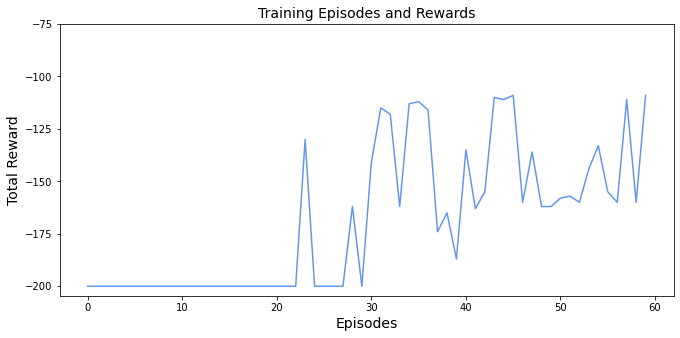

In [7]:
# Plot all episodes rewards
plt.figure(figsize=(11,5))
plt.plot(rewards_train_episodes, "cornflowerblue")
plt.yticks(np.arange(-200,-50, 25))
plt.title("Training Episodes and Rewards", fontsize=14)
plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Total Reward", fontsize=14);

## **Evaluation**

In order for the policy to be considered a solution, it needs to be able to yield an average reward of -110 or higher for 100 consecutive episodes.

In [8]:
%%time
# Run 100 episodes (without additonal training)
rewards_eval_episodes = evaluate_policy(env, agent)
average_reward = round(np.mean(rewards_eval_episodes), 3)
print(f'\nAvg. Reward = {average_reward}\n' )

Finished running 100 episodes for evaluation of policy.

Avg. Reward = -104.48

CPU times: user 1.61 s, sys: 57.7 ms, total: 1.67 s
Wall time: 1.57 s


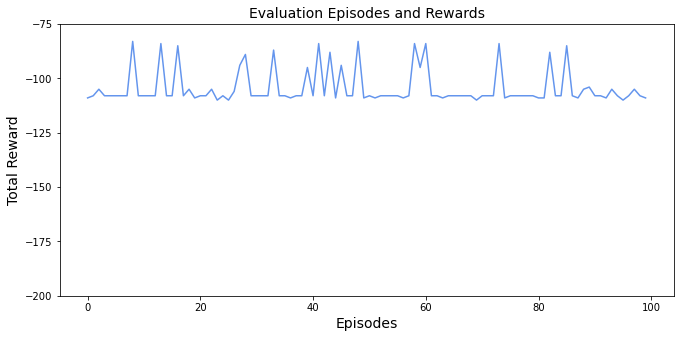

In [9]:
# Plot rewards from evaluation episodes
plt.figure(figsize=(11,5))
plt.plot(rewards_eval_episodes, 'cornflowerblue')
plt.title("Evaluation Episodes and Rewards", fontsize=14)
plt.yticks(np.arange(-200,-50, 25))
plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Total Reward", fontsize=14);

In [10]:
#env.close() #to close display screen

The SARSA method on its own was able to solve this problem in around 400 episodes in a few minutes. The SARSA Lambda approach solved it by training for only 60 episodes in a 3 seconds!

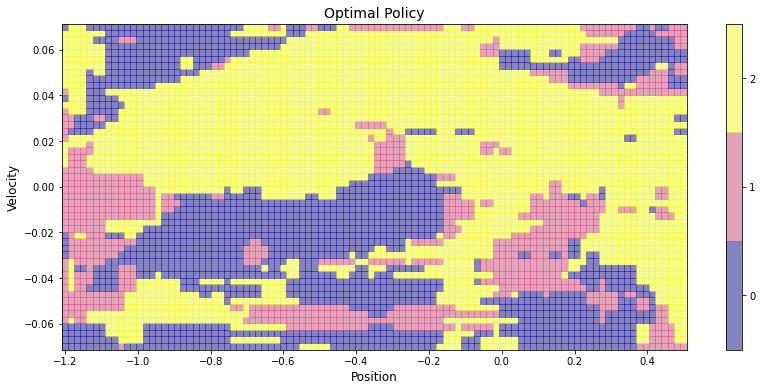

In [12]:
# Plot policy: best actions for each state

position_range = np.linspace(-1.2, 0.5, 100)
velocity_range = np.linspace(-0.07, 0.07, 50)
positions, velocities = np.meshgrid(position_range, velocity_range)

@np.vectorize
def policy(position, velocity):
    return agent.getAction((position, velocity))

actions = policy(positions, velocities)

fig, ax = plt.subplots(figsize=(14,6))
c_plot = ax.pcolormesh(positions, velocities, actions, cmap='plasma',\
                       shading='auto', alpha=0.5)
ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Velocity', fontsize=12)
ax.set_title("Optimal Policy", fontsize=14)
fig.colorbar(c_plot, ax=ax, boundaries=[-.5, .5, 1.5, 2.5], ticks=[0,1,2]);